## Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

# NLP Libraries
from hazm import Normalizer as HazmNormalizer, word_tokenize, Lemmatizer, stopwords_list
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering & Evaluation
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors

# Plotting Configuration
sns.set(style="whitegrid")
%matplotlib inline

## Data Loading & Advanced Preprocessing

In [2]:
# 1. Load Data
try:
    df = pd.read_csv('data/golestan.csv')
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'golestan.csv' not found in the 'data/' folder.")

# 2. Text Preprocessing Setup
normalizer = HazmNormalizer()
lemmatizer = Lemmatizer()

# Define Stopwords
# Combining default Hazm stopwords with high-frequency, non-informative words in Golestan
stop_words = set(stopwords_list())
custom_stops = {
    'گفت', 'گفتا', 'می‌گفت', 'بگفت', 'گویند', 'گفتم', 'گفتند', # Variations of "Said"
    'دید', 'دیدم', 'بدید', 'نظری', 'شنیدم', 'شنید',             # Variations of "Saw/Heard"
    'رفت', 'برفت', 'آمد', 'درآمد', 'بازآمد', 'آید', 'نیامد',    # Variations of "Went/Came"
    'یکی', 'کسی', 'کس', 'مردی', 'شخصی', 'بنده', 'مرا', 'او', 'من', 'تو', # Pronouns
    'بود', 'شد', 'گشت', 'گردید', 'است', 'نیست', 'دارد', 'کرد', 'کنند',   # Common verbs
    'باشد', 'نباشد', 'شدی', 'بودی', 'گر', 'چو', 'افتاد', 'همی', 'ماند', 'داد',
    'کن', 'دانست', 'توان', 'باری', 'ای', 'که', 'از', 'به', 'در', 'را', 'با', 'و'
}
stop_words.update(custom_stops)

def clean_persian_text(text):
    """
    Cleans Persian text by normalizing, removing punctuation/numbers,
    tokenizing, removing stopwords, and lemmatizing.
    """
    if not isinstance(text, str):
        return ""
    
    # 1. Normalization (fix spacing, half-spaces)
    text = normalizer.normalize(text)
    
    # 2. Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # 3. Tokenization
    tokens = word_tokenize(text)
    
    # 4. Stopword Removal & Lemmatization
    cleaned_tokens = []
    for t in tokens:
        if t not in stop_words and len(t) > 1:
            # Hazm lemmatizer returns 'past#present'. We take the root.
            lemma = lemmatizer.lemmatize(t).split('#')[0]
            if lemma not in stop_words:
                cleaned_tokens.append(lemma)
                
    return " ".join(cleaned_tokens)

# Apply cleaning
print("Processing text...")
df['clean_text'] = df['hekayt'].apply(clean_persian_text)

# Show a sample
print("\nSample Cleaned Text:")
print(f"Original: {df['hekayt'].iloc[0][:50]}...")
print(f"Cleaned : {df['clean_text'].iloc[0][:50]}...")

Dataset loaded successfully. Shape: (290, 2)
Processing text...

Sample Cleaned Text:
Original: پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بیچاره...
Cleaned : پادشاه کشتن اسیر اشارت بیچاره حالت نومید ملک دشنام...


## Vectorization (TF-IDF) & LSA

In [3]:
# 1. TF-IDF Vectorization
# Ignoring terms that appear in less than 3 docs or more than 90% of docs
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.9, ngram_range=(1,1))
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

# 2. Dimensionality Reduction (LSA / TruncatedSVD)
# Text data is high-dimensional and sparse. Reducing dimensions helps clustering algorithms.
n_components = 15
lsa = TruncatedSVD(n_components=n_components, random_state=42)
X_lsa = lsa.fit_transform(X_tfidf)

# 3. Normalization
# K-Means uses Euclidean distance. Normalizing to L2 (unit sphere) makes it behave 
# like Cosine Similarity, which is better for text.
normalizer_vec = Normalizer(norm='l2')
X_final = normalizer_vec.fit_transform(X_lsa)

print(f"Final Feature Matrix Shape: {X_final.shape}")

TF-IDF Matrix Shape: (290, 1389)
Final Feature Matrix Shape: (290, 15)


## K-Means Clustering (K=5)

In [4]:
# --- Task 1: Cluster into 5 groups ---
k = 5
kmeans_5 = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_5 = kmeans_5.fit_predict(X_final)

# Add labels to dataframe
df['cluster_k5'] = labels_5

def get_top_keywords(data_tfidf, labels, vectorizer, n_terms=5):
    """
    Extracts top keywords for each cluster based on mean TF-IDF scores.
    """
    # Create a temporary DF with original TF-IDF values
    df_temp = pd.DataFrame(data_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    df_temp['label'] = labels
    
    # Calculate mean vector for each cluster
    cluster_means = df_temp.groupby('label').mean()
    
    # Extract top words
    print(f"\n--- Top {n_terms} Words per Cluster ---")
    for i, row in cluster_means.iterrows():
        # Get indices of top values
        top_indices = np.argsort(row)[-n_terms:][::-1]
        top_words = [row.index[idx] for idx in top_indices]
        print(f"Cluster {i}: {', '.join(top_words)}")

# Show keywords
get_top_keywords(X_tfidf, labels_5, tfidf_vectorizer)


--- Top 5 Words per Cluster ---
Cluster 0: دشمن, دوست, دوستان, دست, مار
Cluster 1: سخن, نادان, بهر, بدان, علم
Cluster 2: ملک, سر, سلطان, پادشاه, نعمت
Cluster 3: دست, سر, جوان, دل, درویش
Cluster 4: پسر, پدر, سنگ, خورد, روز


## Elbow Method & Silhouette Analysis

Running Elbow and Silhouette analysis...


100%|██████████| 13/13 [00:01<00:00, 11.64it/s]


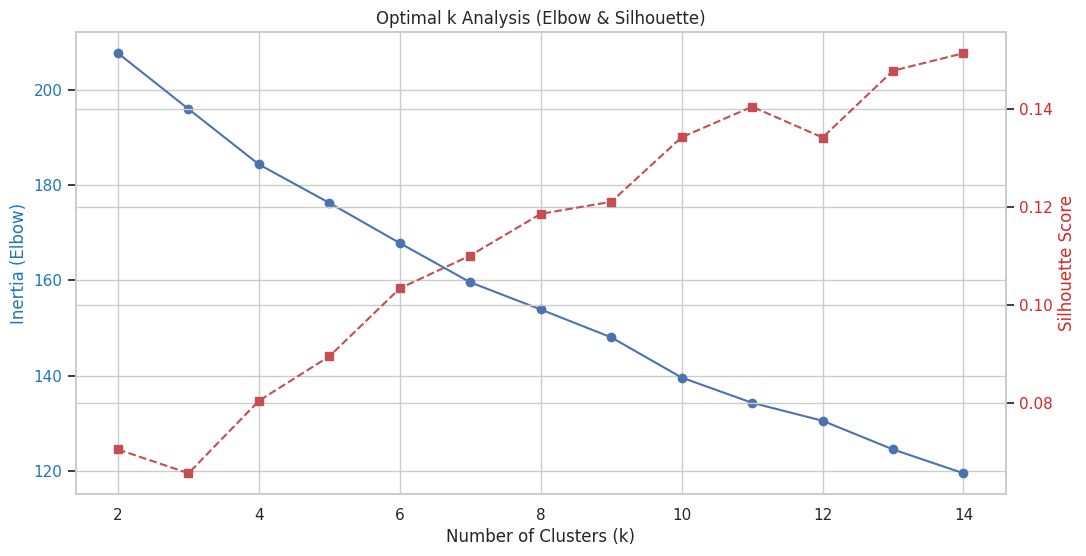

In [5]:
# --- Task 2: Determine optimal K ---
inertia = []
sil_scores = []
K_range = range(2, 15)

print("Running Elbow and Silhouette analysis...")
for k in tqdm(K_range):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_final)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_final, km.labels_))

# Plotting results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Inertia (Elbow)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(K_range, inertia, 'bo-', label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Silhouette
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)  
ax2.plot(K_range, sil_scores, 'rs--', label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Optimal k Analysis (Elbow & Silhouette)')
plt.grid(True)
plt.show()

## Final K-Means & Comparison with Real Chapters (Babs)


Running final K-Means with K=11...

Cluster Sizes:
cluster_opt
0     14
1     49
2     31
3     23
4     31
5     18
6     19
7     29
8     43
9     15
10    18
Name: count, dtype: int64


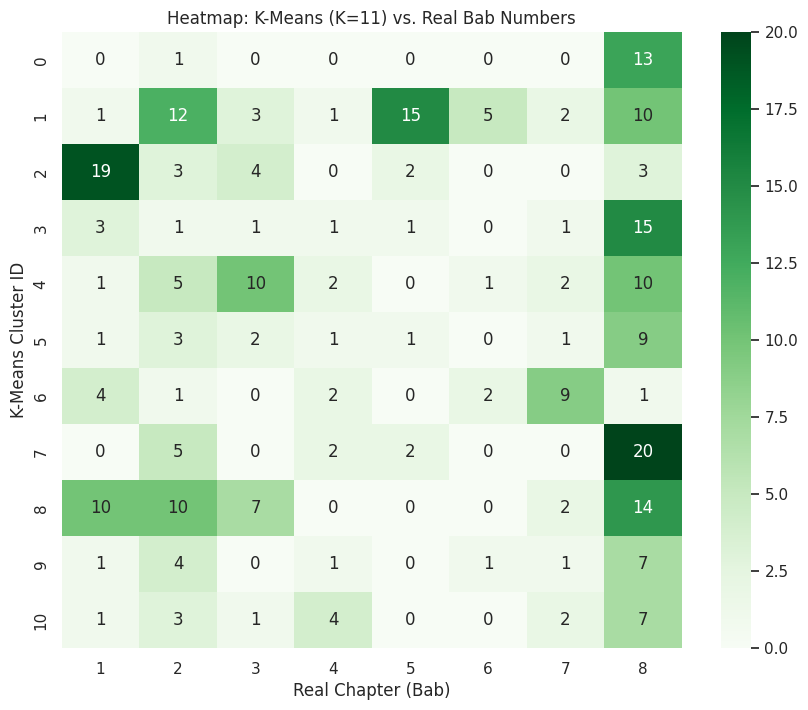


--- 🔑 Top Keywords per K-Means Cluster ---

--- Top 5 Words per Cluster ---
Cluster 0: نیک, بدان, راست, میکند, دولت
Cluster 1: سر, دست, جوان, پیر, دوست
Cluster 2: ملک, سر, پادشاه, فرمود, زاهد
Cluster 3: دشمن, دوست, دست, دوستان, مار
Cluster 4: خورد, دست, بد, سختی, ماه
Cluster 5: سنگ, خاک, هنر, سگ, لعل
Cluster 6: پدر, پسر, مادر, فرزند, ترسید
Cluster 7: نادان, عالم, خردمند, علم, پند
Cluster 8: درویش, خدا, نان, توانگر, خلق
Cluster 9: بهر, عابد, قرآن, خورد, قاضی
Cluster 10: سخن, مگو, گفتن, نادان, فلان


In [6]:
# --- Final K-Means & Comparison with Real Chapters ---

# Based on Elbow/Silhouette analysis and consistency with DBSCAN, we choose K=11
# (Note: While Golestan has 8 chapters, semantic analysis suggests 11 distinct topic clusters)
optimal_k = 11  # <--- Changed from 8 to 11 based on your finding

print(f"\nRunning final K-Means with K={optimal_k}...")

kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df['cluster_opt'] = kmeans_opt.fit_predict(X_final)

# Check cluster sizes
print("\nCluster Sizes:")
print(df['cluster_opt'].value_counts().sort_index())

# Create Confusion Matrix (Crosstab)
crosstab = pd.crosstab(df['cluster_opt'], df['bab'])

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Greens')
plt.title(f'Heatmap: K-Means (K={optimal_k}) vs. Real Bab Numbers')
plt.xlabel('Real Chapter (Bab)')
plt.ylabel('K-Means Cluster ID')
plt.show()

# Extract Keywords for new K=11 clusters
print("\n--- 🔑 Top Keywords per K-Means Cluster ---")
get_top_keywords(X_tfidf, df['cluster_opt'], tfidf_vectorizer)

## DBSCAN Clustering

Running DBSCAN with Eps=0.64 and Min_Samples=3...

Final Results:
• Clusters Found: 13
• Noise Points: 96

• Cluster Size Distribution:
cluster_dbscan
-1     96
 0     28
 1     99
 2      3
 3      5
 4      4
 5     12
 6      4
 7     14
 8     15
 9      4
 10     3
 11     3
Name: count, dtype: int64


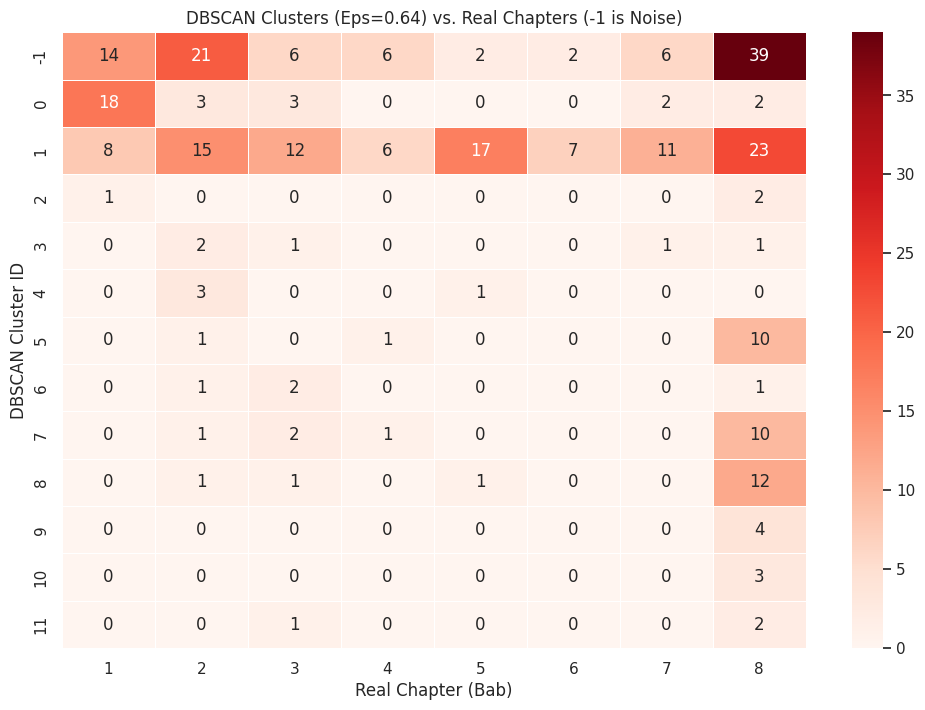


   🔑 Top 5 Keywords per DBSCAN Cluster
Cluster  0: ملک, پادشاه, سر, زاهد, فرمود
Cluster  1: دست, سخن, سر, دل, بهر
Cluster  2: زر, جان, بخیل, سپاه, دون
Cluster  3: سر, امید, فتاده, پیاده, گردن
Cluster  4: دختر, لب, قاضی, وقت, نابینا
Cluster  5: نادان, دانا, علم, وگر, عیب
Cluster  6: خورد, طعام, برآید, خوردن, قضا
Cluster  7: سنگ, سگ, لعل, خاک, قدر
Cluster  8: دشمن, دوست, دوستان, مار, دست
Cluster  9: بدان, نیک, دولت, رحمت, جاه
Cluster 10: راست, دروغ, نیک, گفتن, جامه
Cluster 11: دست, جور, بدخو, سیم, دراز


In [7]:
# --- Task 3: DBSCAN Clustering (Final & Clean) ---

# 1. Configuration (Based on previous optimization)
final_eps = 0.64
final_min_samples = 3

print(f"Running DBSCAN with Eps={final_eps} and Min_Samples={final_min_samples}...")

# 2. Apply Model
dbscan = DBSCAN(eps=final_eps, min_samples=final_min_samples)
df['cluster_dbscan'] = dbscan.fit_predict(X_final)

# 3. Statistics
n_clusters = len(set(df['cluster_dbscan'])) - (1 if -1 in df['cluster_dbscan'] else 0)
n_noise = list(df['cluster_dbscan']).count(-1)

print(f"\nFinal Results:")
print(f"• Clusters Found: {n_clusters}")
print(f"• Noise Points: {n_noise}")

print("\n• Cluster Size Distribution:")
print(df['cluster_dbscan'].value_counts().sort_index())

# 4. Visualization: Heatmap
# This compares the DBSCAN clusters with the real chapters (Babs)
crosstab_db = pd.crosstab(df['cluster_dbscan'], df['bab'])
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_db, annot=True, fmt='d', cmap='Reds', linewidths=.5)
plt.title(f'DBSCAN Clusters (Eps={final_eps}) vs. Real Chapters (-1 is Noise)')
plt.ylabel('DBSCAN Cluster ID')
plt.xlabel('Real Chapter (Bab)')
plt.show()

# 5. Extract Top 5 Keywords for Each Cluster
print("\n" + "="*40)
print("   🔑 Top 5 Keywords per DBSCAN Cluster")
print("="*40)

def get_dbscan_keywords(data_tfidf, labels, vectorizer, n_terms=5):
    """
    Extracts keywords by averaging TF-IDF vectors for each cluster.
    Ignores Noise points (-1).
    """
    # Convert sparse matrix to dense dataframe for grouping
    df_temp = pd.DataFrame(data_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    df_temp['label'] = labels
    
    # Filter out noise (-1) and calculate mean vector for each cluster
    # This finds the "center" of the cluster
    means = df_temp[df_temp['label'] != -1].groupby('label').mean()
    
    for i, row in means.iterrows():
        # Get indices of top values
        top_indices = np.argsort(row)[-n_terms:][::-1]
        top_words = [row.index[idx] for idx in top_indices]
        
        print(f"Cluster {i:>2}: {', '.join(top_words)}")

# Run extraction
if n_clusters > 0:
    get_dbscan_keywords(X_tfidf, df['cluster_dbscan'], tfidf_vectorizer, n_terms=5)
else:
    print("No valid clusters found to extract keywords.")